# Exploratory Analysis of Cryptic Crossword Data

Dataset created by George Ho. 

Available for download: https://cryptics.georgeho.org/data.db

In [59]:
# imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Connect to the sqlite3 file
data_file = "../data/data.sqlite3"
conn = sqlite3.connect(data_file)

In [3]:
# Check what data tables exist in the file
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

,name
0,indicators_by_clue
1,indicators_consolidated
2,charades_by_clue
3,clues
4,charades
5,indicators
6,metadata
7,clues_fts
8,clues_fts_data
9,clues_fts_idx


In [4]:
# Ignore metadata and any table involving 'fts' (fast text search) for now.
# See how big the remaining tables.

tables = [
    "clues",
    "indicators",
    "charades",
    "indicators_by_clue",
    "charades_by_clue",
    "indicators_consolidated"
]

summary = []

for t in tables:
    # count rows
    row_count = pd.read_sql(f"SELECT COUNT(*) AS n FROM {t};", conn).iloc[0]["n"]
    
    # count rows and columns
    col_info = pd.read_sql(f"PRAGMA table_info({t});", conn)
    col_count = len(col_info)

    summary.append({
        "table": t,
        "rows": row_count,
        "columns": col_count
    })

summary_df = pd.DataFrame(summary)
summary_df.style.format({"rows": "{:,}"}) # display with commas 
#summary_df

,table,rows,columns
0,clues,"660,613",9
1,indicators,"15,735",4
2,charades,"57,289",4
3,indicators_by_clue,"88,037",9
4,charades_by_clue,"126,825",3
5,indicators_consolidated,1,8


In [5]:
# Create some dataframes
clues_df = pd.read_sql("SELECT * FROM clues;", conn)
indicators_df = pd.read_sql("SELECT * FROM indicators;", conn)
charades_df = pd.read_sql("SELECT * FROM charades;", conn)

ind_by_clue_df = pd.read_sql("SELECT * FROM indicators_by_clue;", conn)
charades_by_clue_df = pd.read_sql("SELECT * FROM charades_by_clue;", conn)
indicators_consolidated_df = pd.read_sql("SELECT * FROM indicators_consolidated;", conn)

In [6]:
# The Indicators Consolidated provides a list of all indicators, grouped by type.
# The types are the eight columns in indicators_consolidated_df
indicators_consolidated_df.columns


Index(['alternation', 'anagram', 'container', 'deletion', 'hidden',
       'homophone', 'insertion', 'reversal'],
      dtype='object')

In [7]:
# For example, look at alternation (aka selection) words found in the clues.
alternation_string = indicators_consolidated_df["alternation"].iloc[0]
#print(alternation_string)
print(len(alternation_string.split("\n")))

244


In [8]:
# Helper function to transform the dataframe
# where each column is category of indicators, and
# the one row contains a string of all instances within that category
def inds_df_to_dict(df):
    
    inds_dict = {}
    for category in list(df.columns):
        inds_dict[category] = df[category].iloc[0].split("\n")
        
    return inds_dict

In [9]:
# Create a dictionary of consolidated indicators, where
# keys are the category, and
# values are a list of all instances within that category
indicators_dict = inds_df_to_dict(indicators_consolidated_df)

In [10]:
print("Category\tCount")
print("----------------------")
for key in indicators_dict:
    print(key, "\t", len(indicators_dict[key]))

Category	Count
----------------------
alternation 	 244
anagram 	 7346
container 	 1950
deletion 	 877
hidden 	 1110
homophone 	 669
insertion 	 2173
reversal 	 1692


In [11]:
for ind in indicators_dict['homophone']:
    print(ind)

a report on
according to announcement
according to careless whisper
according to hearsay
according to report
according to reports
according to speaker
according to the gossip
according to the listener
acoustic
addressed
admitting
advertised
after audition
after hearing
after listening to
after performance
aired
all told
allegedly
aloud
amplifying call
announced
announcement
announcement of
announcing
apparently
appreciated by the audience
approximated in speech
are heard
articulate
articulated
as advertised on the radio
as announced
as discussed
as has been said
as one might say
as one says
as quoted
as reported
as reported on the radio
as satnav says
as some might say
as some say
as some would tell it
as sound
as spoken
as stated
as that sounds
as the saying goes
as they say
as told
as we hear
as we may hear it
as we say
as you can hear
as you may say
as you might say
as you say
asked for
at hearing
at the auditors
audible
audibly
audibly received
audio
audio version
audiobook confuse

In [12]:
# Take a peek at the instances of "hidden" indicators (words or phrases) found.
# Some of the instances are probably wrong because they are not words,
# like 'y', 'wil', 'w', 'th', 'sof', 'se', 'li', 'lif', 'l', 'h', 'ha', 'disli', 'c', 'bos', 'b'.
# Others are questionable because even though they are words, it's hard to decipher
# how they indicate "hidden": 'ant'
for ind in indicators_dict['hidden']:
    print(ind)

a bit
a bit of
a bit of this
a bunch of
a certain amount of
a component
a group of
a little
a lot of
a part of
a piece of
a piece to
a pinch of
a place for
a portion of
a section
a selection of
a spot of
abducted by
aboard
about
absorbed
absorbed by
absorbed in
absorbs
abstract
accept
accepted by
accepting
accommodates
accommodating
accounting for some
acquired from
across
admits
admitted
admitted to
admitting
adopted
adopted by
after loss
all over
amid
among
amongst
an amount of
an element in
an extract from
an integral part
anchored
ant
apparently
appearing
appearing in
appears in
arising in
around
arresting
as setting for
aspect of
aspects of
assimilated by
at heart
available from
b
back in
back out of
bagged
bags
bandages
bars in
based
bears
bee
being
being cornered by
being cuddled by
belonging to
beneath mask of
besieging
between
bit
bit of
bites
bits
bits of
blocked
boarding
bos
bottled
bottled up
bottles
bottling
bouncing back
bound by
box
boxed by
boxes
boxing
brackets
brandis

### Idea for Analysis: How well do instances of indicators group into their categories?
Unsupervised Learning: Working with the consolidated indicators, we could perform some sort of data cleaning and word normalization, and then cluster them. Does the dataset form human-recognizable clusters? Does it cluster into the eight categories given in the `consolidated_indicators` table? What about other classification schemes for cryptic crossword indicators: for example, Minute Cryptic uses the category "selector" rather than "alternation" and "substitution" rather than "insertion".

If we have a cluster of similar words, is it possible to determine an eigenword for each cluster, something that most clearly represents the central meaning of that cluster? Is it problematic that some indicators are phrases rather than words?

NOTE: In order for this to be considered supervised learning, we need to verify how the indicator for each clue was derived and how it was categorized. According to the datasheet, it sounds like these were determined from parsing the blog data:

"The fourth part is to run each parsed annotation through a series of regular expressions to extract any indicators or charades that have been identified by the blogger in the annotation. It’s important to note that not all clues have annotations, and of those that do, not all of them clearly identify indicators and charades clearly enough to be extracted using a regular expression. In other words, regular expressions are high-precision, low-recall methods of identifying indicators and charades. Thus, these derived datasets should not be considered comprehensive - an indicator is not guaranteed to appear in the indicators dataset just because it appears in a clue in the clues dataset."

https://cryptics.georgeho.org/datasheet#collection-process

## Clues

In [13]:
# Considering the ideas above, let's take a closer look at the clues table
clues_df.head()

,rowid,clue,answer,definition,clue_number,puzzle_date,puzzle_name,source_url,source
0,1,"Acquisitive chap, as we see it (8)",COVETOUS,Acquisitive,1a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times
1,2,Back yard fencing weak and sagging (6),DROOPY,sagging,5a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times
2,3,"Stripping off uniform, love holding colonel's ...",UNCLOTHING,Stripping,8a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times
3,4,Without a mark where they should be gained (4),EXAM,where they should be gained,9a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times
4,5,"Put a stop to Rugby's foul school leader (5,2,...",KNOCK ON THE HEAD,Put a stop to,10a,2019-08-08,Times 27424,https://times-xwd-times.livejournal.com/218581...,times_xwd_times


In [86]:
ind_by_clue_df.sample(10)

# same indicator in multiple wordplay columns - mistake, or two types of wordplay?
# 'hidden' and 'insertion' wordplay often use the word 'in', sometimes as part of a phrase: 
#    do the other words in the phrase also suggest that wordplay type, or is "in" doing the heavy lifting?
# The same question goes for words like "for", "to", "by", "of", "when" ... are these stopwords or are they related to wordplay type?

,clue_rowid,alternation,anagram,container,deletion,hidden,homophone,insertion,reversal
32039,350419,,,,,,told,,
73984,587056,,,around,,,,,
22862,310400,,,,,,,,rejected
64601,476413,,agitated,,,,,,
36965,373699,,awkwardly,,,,,,
52087,431157,,drunk,,,,,,
7030,123594,,mixed,,,,,,
41188,393431,,varied,,,,,,
55802,443666,,,,,,sound,,
66312,483221,,in trouble,,,,,,


In [76]:
indicators_df.sample(5)

,rowid,wordplay,indicator,clue_rowids,indicator_wc
13259,13260,insertion,orient,[151911](/data/clues/151911),1
1023,1024,anagram,bringing order,[171721](/data/clues/171721),2
8510,8511,container,presented about,[81361](/data/clues/81361),2
4776,4777,anagram,quavers,[645095](/data/clues/645095),1
12927,12928,insertion,includes,"[362892](/data/clues/362892), [447662](/data/c...",1


In [16]:
indicators_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15735 entries, 0 to 15734
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rowid        15735 non-null  int64 
 1   wordplay     15735 non-null  object
 2   indicator    15735 non-null  object
 3   clue_rowids  15735 non-null  object
dtypes: int64(1), object(3)
memory usage: 491.8+ KB


## Multiple-Word vs One-Word

Multiple words could be harder to deal with when it comes to indicators, definitions, and answers. Let's see how common they are.

In [17]:
clues_df['answer'].info

<bound method Series.info of 0                  COVETOUS
1                    DROOPY
2                UNCLOTHING
3                      EXAM
4         KNOCK ON THE HEAD
                ...        
660608              UPBRAID
660609             TIME LAG
660610               ESTEEM
660611                UNBAR
660612                    Q
Name: answer, Length: 660613, dtype: object>

In [18]:
# Add columns for the word count of answer and definition
clues_df['answer_wc'] = clues_df['answer'].astype(str).str.split().str.len()
clues_df['definition_wc'] = clues_df['definition'].astype(str).str.split().str.len()
clues_df['clue_wc'] = clues_df['clue'].astype(str).str.split().str.len()

In [19]:
# What proportion of answers are multi-word?
clues_df['answer_wc'].value_counts().head(4).sum()

658847

In [20]:
clues_df['definition_wc'].value_counts().head(5).sum()

628183

In [21]:
clues_df['clue_wc'].value_counts().head(13).sum()

655224

That's an indication that this data will require some cleaning. Any definition of length 0 or greater than 6-8 words is highly suspect.


In [22]:
# How many clues are we left with if we only use 1-word definitions and 1-word answers?
clues_df['both_one'] = np.where((clues_df['answer_wc'] == 1) & (clues_df['definition_wc'] == 1), 1, 0) 

In [23]:
clues_df['both_one'].value_counts()

both_one
1    352775
0    307838
Name: count, dtype: int64

In [24]:
indicators_df['indicator_wc'] = indicators_df['indicator'].astype(str).str.split().str.len()

In [25]:
indicators_df.sample(8)

,rowid,wordplay,indicator,clue_rowids,indicator_wc
13575,13576,insertion,smuggled therein,[465092](/data/clues/465092),2
11993,11994,insertion,among,"[37722](/data/clues/37722), [63377](/data/clue...",1
2139,2140,anagram,falls to pieces,[485943](/data/clues/485943),3
11413,11414,homophone,dictated,"[295799](/data/clues/295799), [322585](/data/c...",1
13051,13052,insertion,is enthralled by,[636766](/data/clues/636766),3
3625,3626,anagram,jiggling,"[136690](/data/clues/136690), [213753](/data/c...",1
11173,11174,hidden,to hold back,[56394](/data/clues/56394),3
2853,2854,anagram,going wrong,"[30272](/data/clues/30272), [296992](/data/clu...",2


In [26]:
indicators_df['indicator_wc'].value_counts()

indicator_wc
1    6638
2    6280
3    2149
4     557
5      99
6      11
7       1
Name: count, dtype: int64

How many rows in the clues table could be duplicates? That is, different bloggers provide writeups of the same puzzle.

Sort the clues table by ANSWER, and keep only rows that have answers that aren't unique.

In [45]:
clues_df.sample(5)[['clue', 'clue_wc', 'definition', 'definition_wc', 'answer', 'answer_wc']]

,clue,clue_wc,definition,definition_wc,answer,answer_wc
353293,Adjusted pro rata invoice knocking off one zer...,11,quibbling,1,PREVARICATION,1
310612,Licence charge about right with party millions...,8,Licence,1,FREEDOM,1
255747,Universal law is a thorny thing (4),7,None,1,ULEX,1
265537,"Letters in an anagram are so not working! (3,2,5)",9,,0,OUT OF ORDER,3
355454,"American, not heartless, that may be a soldier...",9,that may be a soldier,5,ANT,1


In [47]:
# How long are the clues? (word count)
clues_df['clue_wc'].value_counts(dropna=False).head(20)

clue_wc
7     122129
8     118421
6      99085
9      93110
10     61158
5      57863
11     35714
4      22946
12     18669
3      10348
13      9205
14      4230
2       2346
15      1979
1       1003
16       933
17       437
0        326
18       217
19       101
Name: count, dtype: int64

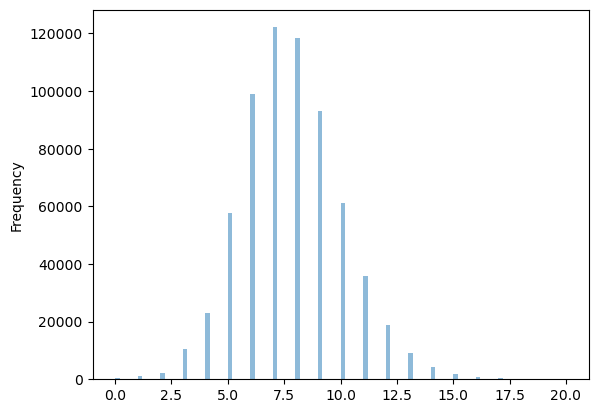

In [97]:
# Make a histogram to visualize clue word length.
# Only consider clues where the word length is 0-20.
df_to_plot = clues_df[clues_df['clue_wc'] <= 20]

plt.figure();
df_to_plot['clue_wc'].plot.hist(alpha=0.5, bins=100);

In [111]:
clues_df['clue_wc'].value_counts().head(20)

clue_wc
7     122129
8     118421
6      99085
9      93110
10     61158
5      57863
11     35714
4      22946
12     18669
3      10348
13      9205
14      4230
2       2346
15      1979
1       1003
16       933
17       437
0        326
18       217
19       101
Name: count, dtype: int64

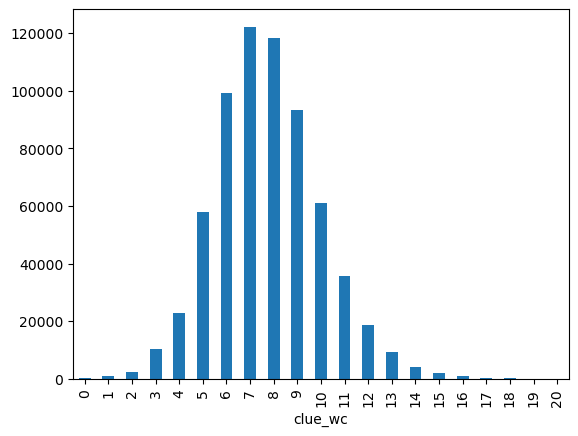

In [108]:
# maybe the plotting works better as a bar chart
# Only consider clues where the word length is 0-20.
df_to_plot = clues_df[clues_df['clue_wc'] <= 20]['clue_wc'].value_counts().sort_index()

plt.figure();
df_to_plot.plot.bar();

In [58]:
clues_df[clues_df['clue_wc'] == 7][['clue', 'definition', 'answer', 'puzzle_date', 'puzzle_name', 'source']].sample(15)

,clue,definition,answer,puzzle_date,puzzle_name,source
400004,Christmas-time may be the main issue (6),Christmas-time may be,SEASON,2015-12-25,Daily Telegraph 100007,bigdave44
208688,"Voyeur on trial, criminal in novel (13)",novel,REVOLUTIONARY,2016-07-31,Guardian Genius No 157 by Picaroon,fifteensquared
614297,Dredge unfinished part of swimming pool (6),Dredge,DEEPEN,2022-02-09,Daily Telegraph 29906,bigdave44
600401,Old Scandinavian calls Hollywood’s Howard bac...,Old Scandinavian,NORSEMAN,2021-12-04,"Saturday, December 4, 2021 — Well Versed in Ne...",natpostcryptic
595944,Neglected child mainly lived life inside (4),Neglected child,WAIF,2021-11-09,Financial Times 16938 by Basilisk,fifteensquared
3161,Sizeable British force on the ground (3),Sizeable,BIG,2018-10-24,Times 27177,times_xwd_times
270429,Tutor with a penchant for haranguing? (8),,LECTURER,2013-12-12,Financial Times No 14494 by Hamilton,fifteensquared
379044,Miss one duet out of tiredness (9),tiredness,LASSITUDE,2016-03-31,Toughie 1578,bigdave44
350676,Harbottle is thrown out by union (9),union,BETROTHAL,2016-06-27,Daily Telegraph 28151,bigdave44
594246,Inherited gut disorder is genetically transmit...,Inherited,RUNS IN THE FAMILY,2021-11-02,Financial Times 16932 by Velia 2,fifteensquared


In [29]:
# Returns all rows where the 'answer' appears more than once
df_clue_duplicates = clues_df[clues_df.duplicated(subset='answer', keep=False)]

In [39]:
df_clue_duplicates[(df_clue_duplicates['answer'] != "") & (df_clue_duplicates['definition'] != "") & df_clue_duplicates['definition'].isna()].sort_values(by="answer")

,rowid,clue,answer,definition,clue_number,puzzle_date,puzzle_name,source_url,source,answer_wc,definition_wc,clue_wc,both_one
658637,661677,"silence already filled with noises,",A,None,Ad,2023-03-27,Rookie Corner 468,http://bigdave44.com/2023/03/27/rookie-corner-...,bigdave44,1,1,5,1
45791,45792,- CAT [spiteful woman] gets A STROPHE [a verse],A,None,CATASTROPHEa,2018-06-02,Times Cryptic Jumbo No 1324,https://times-xwd-times.livejournal.com/195426...,times_xwd_times,1,1,9,1
343810,343811,"Celebrity secrets I lampoon, somewhat upsettin...",A,Celebrity,4d,2017-07-26,Toughie 1853,http://bigdave44.com/2017/07/26/toughie-1853/,bigdave44,1,1,7,1
497221,497222,Is the definition a valid synonym for the solu...,A,None,1d,2014-09-01,Rookie Corner 021,http://bigdave44.com/2014/09/01/rookie-corner-...,bigdave44,1,1,9,1
10892,10893,you try and do a ton,A,None,Tilla,2019-06-08,Times Cryptic No 27366,https://times-xwd-times.livejournal.com/215320...,times_xwd_times,1,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
642896,645936,Europeans punched by awfully grim politically ...,ÉMIGRÉ,politically motivated leaver,23a,2022-11-05,Guardian Prize Picaroon,https://www.fifteensquared.net/2022/11/05/guar...,fifteensquared,1,3,9,0
176813,176814,"Teacher prone to lose heart, flipping besotted...",ÉPRIS,besotted,16d,2019-02-13,Guardian 27743 Picaroon,https://www.fifteensquared.net/2019/02/13/guar...,fifteensquared,1,1,8,1
213669,213670,Last bit of purchase placed on top? One’s capt...,ÉPRIS,One’s captivated,27d,2016-11-06,Azed 2317,https://www.fifteensquared.net/2016/11/06/azed...,fifteensquared,1,2,10,0
603510,606550,"Weapon European repeatedly used, seizing power...",ÉPÉE,Weapon,29d,2021-12-23,Guardian 28636 Brendan,https://www.fifteensquared.net/2021/12/23/guar...,fifteensquared,1,1,7,1
